W poniższej analizie przyjrzymy się związkom między pożarami, koncesjami na handel hurtowy alkoholem oraz zaludnieniem terenu. Niektóre hipotezy na temat korelacji tych danych są łatwe do wysnucia np. przypuszczalnie więcej pożarów występuje na bardziej zaludnionych obszarach. Sprawdzimy tego typu hipotezy, ale co ważniejsze na podstawie danych poszukamy głębiej ukrytych mechanizmów wpływania jednych czynników na inne. Będziemy korzystać z paczki którą przygotowałem w ramach tego projektu.

# Importy

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import pandas as pd
import argparse
import os
import sys 
import matplotlib.pyplot as plt
import pytest
import cProfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import math

In [3]:
from src.project_analiza_Szymon.io_utils.read import load_data_from_folder
#from src.project_analiza_Szymon.preprocessing import *
#from src.project_analiza_Szymon.calculate import *
import src.project_analiza_Szymon.preprocessing as prep
import src.project_analiza_Szymon.calculate as clc
import src.project_analiza_Szymon.plots as pl
from src.project_analiza_Szymon.io_utils.write import *

# Ładowanie danych

In [4]:
datasets = load_data_from_folder("data")

Reading: data\C1.xlsx
Reading: data\nowe_mieszkania.xlsx
Reading: data\powierzchnia_i_ludnosc_w_przekroju_terytorialnym_w_2024_roku_tablice.xlsx
Reading: data\raport_na_dzien_1_września_2023_r.csv
Reading: data\raport_zezwoleń_czynnych_na_dzień_2_września_2024_r.csv


preprocessing

In [5]:
for i in range(len(datasets)):
    print(datasets[i][0])

C1.xlsx
nowe_mieszkania.xlsx
powierzchnia_i_ludnosc_w_przekroju_terytorialnym_w_2024_roku_tablice.xlsx
powierzchnia_i_ludnosc_w_przekroju_terytorialnym_w_2024_roku_tablice.xlsx
raport_na_dzien_1_września_2023_r.csv
raport_zezwoleń_czynnych_na_dzień_2_września_2024_r.csv


In [6]:
pozary_grup_pw = prep.pozary_powiat(datasets[0][1])
pozary_grup_woj = prep.pozary_woj(datasets[0][1])
lud_pow_woj = prep.ludn_woj(datasets[2][1])
koncesje_hurt = prep.koncesje(datasets[5][1])
koncesje_2023 = prep.koncesje(datasets[4][1])

brak na
 Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
powiat                           0
dtype: int64
brak na
 Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
Województwo                      0
dtype: int64
brak na
 Województwo            0
powierzchnia w km^2    0
Ludność ogółem         0
Ludność na km^2        0
dtype: int64
brak na
 liczba_zezwolen    0
Województwo        0
dtype: int64
brak na
 liczba_zezwolen    0
Województwo        0
dtype: int64


In [7]:
mieszk = prep.nowe_mieszkania(datasets[1][1])


Są wszystkie woj: 16
brak na
 Województwo             0
nowe_mieszkania_2023    0
nowe_mieszkania_2024    0
dtype: int64


In [8]:
pozary_2023 = prep.pozary_wczesniej(datasets[0][1])
ludn_pow_2024_pow = prep.ludn_powiat(datasets[3][1])

df_ludn_poz = prep.lacz_ludn_pozar(ludn_pow_2024_pow, pozary_grup_pw)

brak na
 Pożary rok 2023    0
Województwo        0
dtype: int64
w danych są przerwy np.             powiaty powierzchnia w km^2 Ludność ogółem      Ludność na km^2
0               NaN       w km²\nin km²  ogółem\ntotal  na 1 km²\nper 1 km²
1               NaN                 NaN            NaN                  NaN
2          Powiaty:                 NaN            NaN                  NaN
3          Powiats:                 NaN            NaN                  NaN
4     bolesławiecki                1303          87642                   67
liczby braków w kol.: powiaty                0
powierzchnia w km^2    4
Ludność ogółem         4
Ludność na km^2        4
dtype: int64
braki są w tych samych wierszach: 
powierzchnia : Index([190, 191, 304, 305], dtype='int64')
ludnosc ogolem: Index([190, 191, 304, 305], dtype='int64')
Ludność na km^2 : Index([190, 191, 304, 305], dtype='int64')
                        powiaty powierzchnia w km^2 Ludność ogółem  \
190   Miasto na prawach powiatu       

In [9]:
df_lud_zez_poz = prep.lacz_trzy(lud_pow_woj, koncesje_hurt, pozary_grup_woj)

braki: Województwo                      0
powierzchnia w km^2              0
Ludność ogółem                   0
Ludność na km^2                  0
liczba_zezwolen                  0
Ogółem zdarzeń rok 2024          0
Pożary rok 2024                  0
Miejscowe zagrożenia rok 2024    0
dtype: int64


In [10]:
pozary_2023.head()
df = pd.DataFrame({
        'Województwo': ['A', 'A', 'B', 'B'],
        'Pożary rok 2023': [1, 2, 3, 4],
        'Inna kol': [5, 6, 7, 8]
    })
prep.pozary_wczesniej(df)["Pożary rok 2023"]

brak na
 Pożary rok 2023    0
Województwo        0
dtype: int64


0    3
1    7
Name: Pożary rok 2023, dtype: int64

Nie było żadnych strat rekordów podczas preprocessingu, co uwidocznione jest na dosyć długim tekście pod komórkami.

# Zależności między zaludnieniem a liczbą pożarów oraz zaludnieniem a liczbą zezwoleń na hurtowy handel alkoholami

Najpierw przyjrzyjmy się podstawowym informacją dotyczącym tych danych

In [11]:
print(f'najwięcej pożarów (liczba, powiat): {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[0][0]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[0][1]}')
print(f'największa ludność (liczba, powiat): {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[0][0]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[0][1]}')
print(f'najwięcej koncesji (liczba, województwo): {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[0][0]}, {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[0][1]}')

print(f'min, średnia i mediana liczby pożarów: {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[1][0]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[2]}, {clc.simple_stat(df_ludn_poz["Pożary rok 2024"], df_ludn_poz.powiat)[3]}')
print(f'min, średnia i mediana liczby ludności: {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[1][0]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[2]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[3]}')
print(f'min, średnia i mediana liczby zezwoleń: {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[1][0]}, {clc.simple_stat(koncesje_hurt["liczba_zezwolen"], koncesje_hurt["Województwo"])[2]}, {clc.simple_stat(df_ludn_poz["Ludność ogółem"], df_ludn_poz.powiat)[3]}')


najwięcej pożarów (liczba, powiat): 4251, Warszawa
największa ludność (liczba, powiat): 1861599, Warszawa
najwięcej koncesji (liczba, województwo): 131, mazowieckie
min, średnia i mediana liczby pożarów: 50, 286.63, 218.0
min, średnia i mediana liczby ludności: 18645, 99043.44, 73723.0
min, średnia i mediana liczby zezwoleń: 4, 26.0, 73723.0


,liczba_zezwolen,Województwo
0,18,dolnośląskie
1,13,kujawsko-pomorskie
2,13,lubelskie
3,4,lubuskie
4,131,mazowieckie


In [60]:
df_ludn_poz[['Pożary rok 2024', "Ludność ogółem"]].corr()

,Pożary rok 2024,Ludność ogółem
Pożary rok 2024,1.000000,0.922357
Ludność ogółem,0.922357,1.000000


In [65]:
df_trzy_dane = df_lud_zez_poz[["Ludność ogółem", "liczba_zezwolen", "Pożary rok 2024"]]
df_trzy_dane.corr()

,Ludność ogółem,liczba_zezwolen,Pożary rok 2024
Ludność ogółem,1.000000,0.877855,0.924436
liczba_zezwolen,0.877855,1.000000,0.873948
Pożary rok 2024,0.924436,0.873948,1.000000


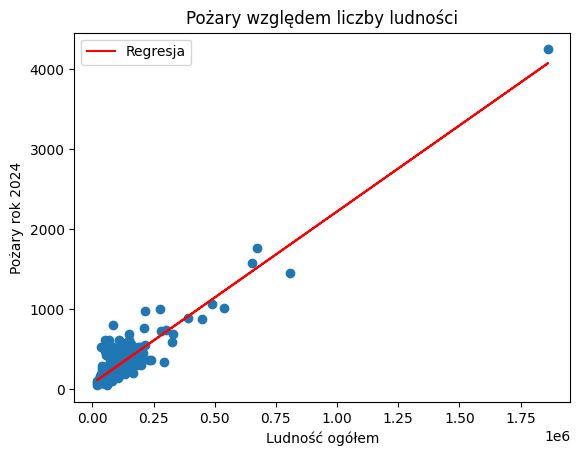

In [15]:
pl.plot_regr_poz_lud(df_ludn_poz["Ludność ogółem"], df_ludn_poz["Pożary rok 2024"])

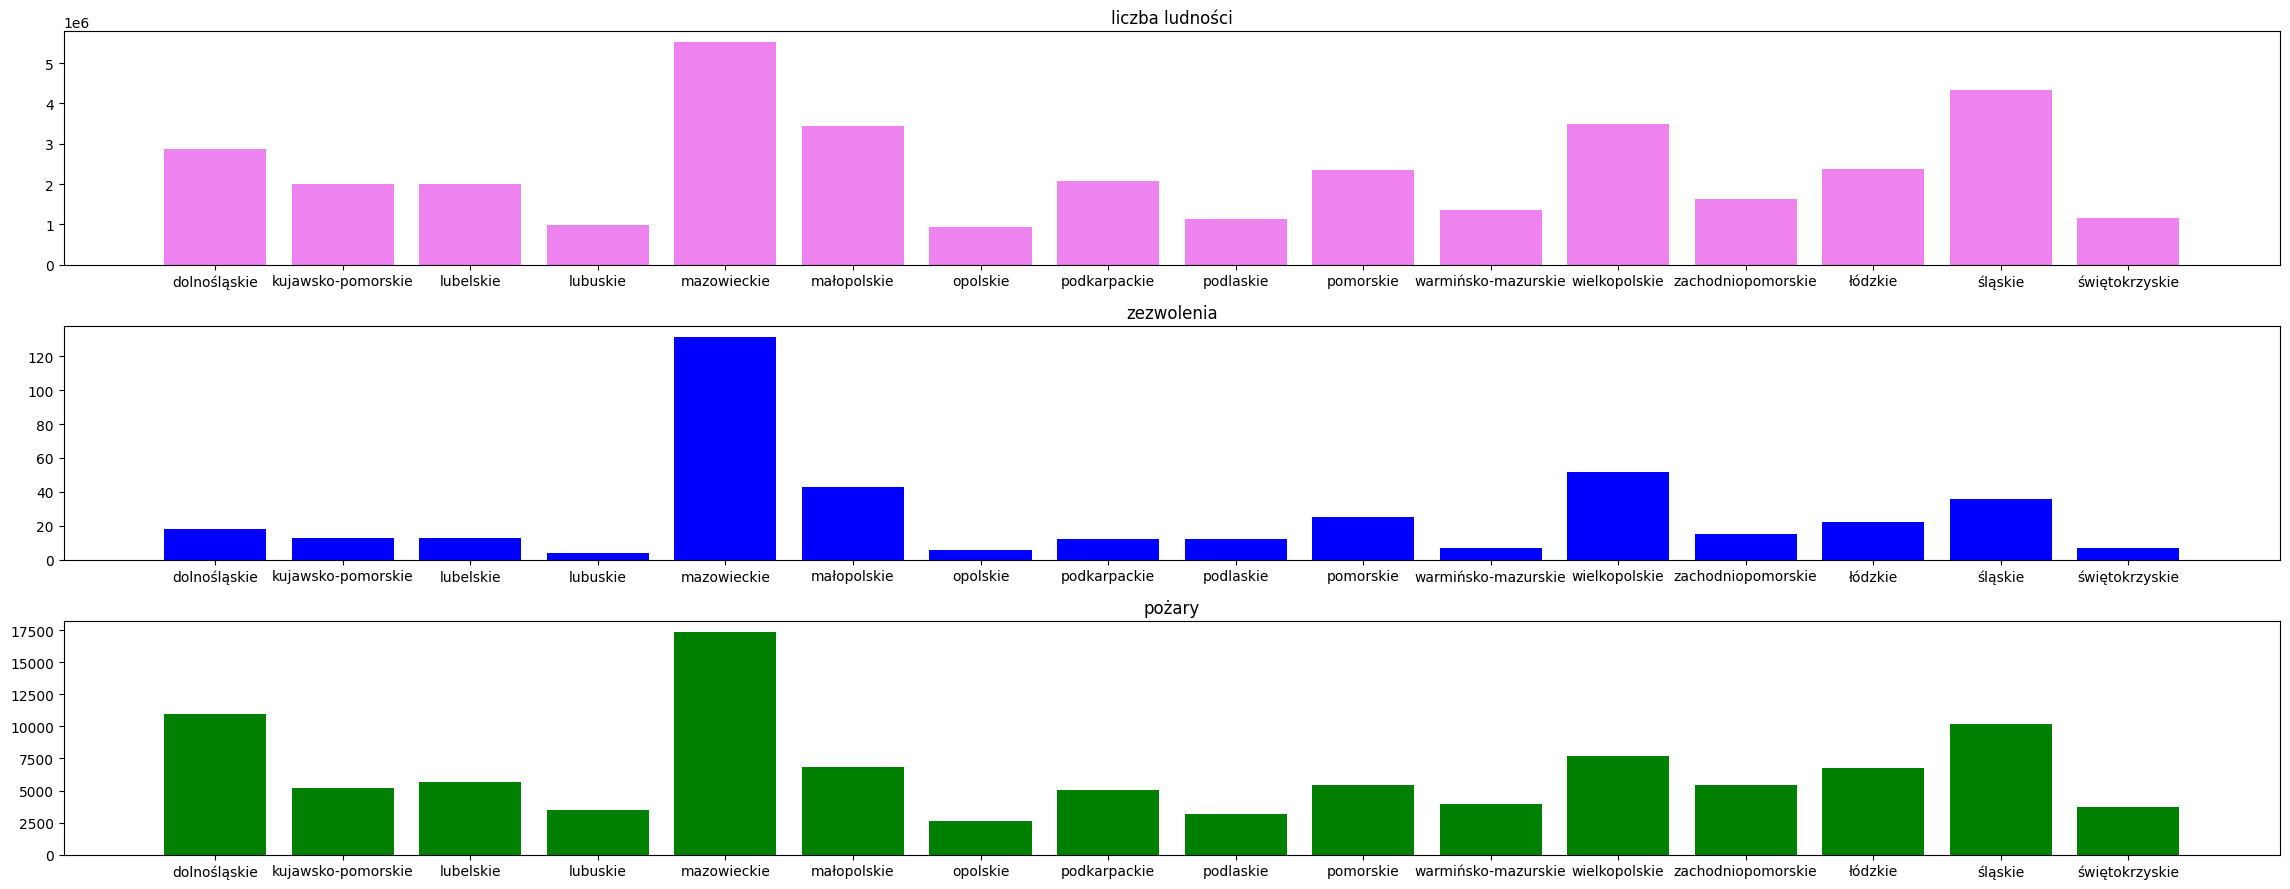

In [16]:
pl.plot_barplots(df_lud_zez_poz['Województwo'], df_lud_zez_poz["Ludność ogółem"], df_lud_zez_poz["liczba_zezwolen"], df_lud_zez_poz["Pożary rok 2024"])

In [17]:
print(clc.stat_wplyw_outlier(df_ludn_poz["Ludność ogółem"], df_ludn_poz["Pożary rok 2024"])[2])
#print(np.sort(clc.stat_wplyw_outlier(df_ludn_poz["Ludność ogółem"], df_ludn_poz["Pożary rok 2024"])[1]))


[54]


In [18]:
print(df_ludn_poz.iloc[54, :])


powiat                           Warszawa
powierzchnia w km^2                   517
Ludność ogółem                    1861599
Ludność na km^2                      3599
Ogółem zdarzeń rok 2024             22846
Pożary rok 2024                      4251
Miejscowe zagrożenia rok 2024       13139
Name: 54, dtype: object


In [19]:
koncesje_2024 = koncesje_hurt.rename(columns={'liczba_zezwolen': 'liczba_zezwolen_2024'})
koncesje_2023 = koncesje_2023.rename(columns={'liczba_zezwolen': 'liczba_zezwolen_2023'})
zezw_przyr = clc.przyrosty_w_woj(koncesje_2024, koncesje_2023, 'liczba_zezwolen_2024', 'liczba_zezwolen_2023')
zezw_przyr.head()

,przyrost,Województwo
0,-5,dolnośląskie
1,2,kujawsko-pomorskie
2,-4,lubelskie
3,1,lubuskie
4,5,mazowieckie


In [42]:
poz_przyr = clc.przyrosty_w_woj(pozary_grup_woj ,pozary_2023, "Pożary rok 2024", "Pożary rok 2023")
poz_przyr = poz_przyr.rename(columns={'przyrost': 'przyrost_poz'})
zezw_przyr = zezw_przyr.rename(columns={'przyrost': 'przyrost_zezw'})
por_przyr = pd.merge(poz_przyr, zezw_przyr, on="Województwo")
por_przyr.head()

,przyrost_poz,Województwo,przyrost_zezw
0,1336,dolnośląskie,-5
1,-355,kujawsko-pomorskie,2
2,683,lubelskie,-4
3,73,lubuskie,1
4,1119,mazowieckie,5


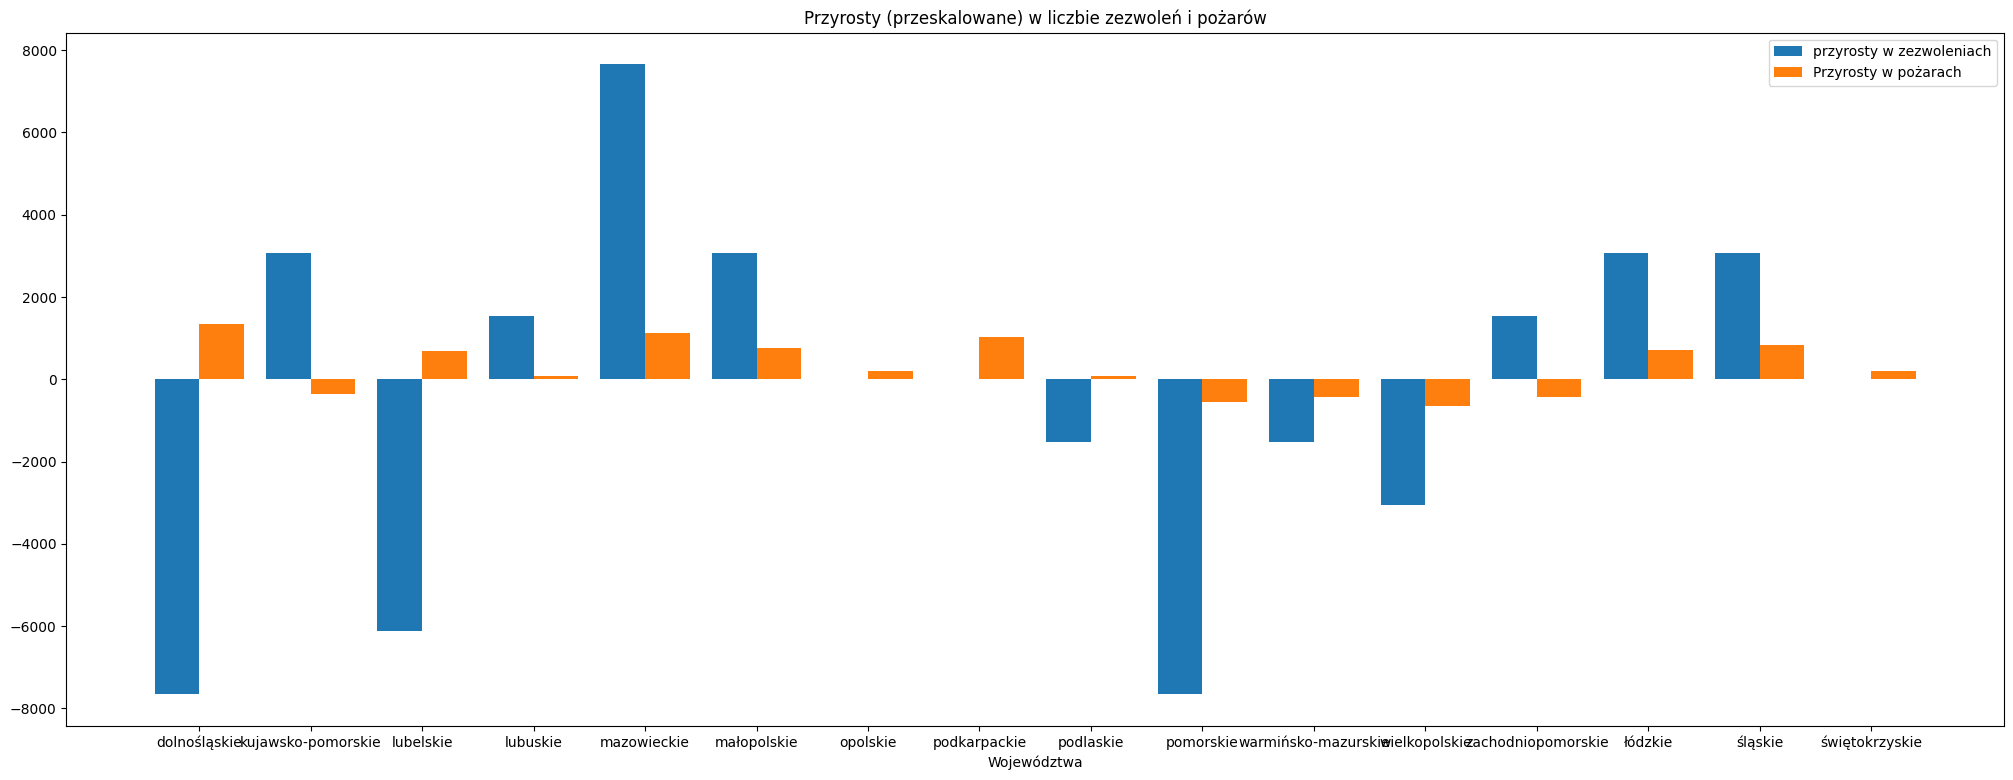

In [55]:
pl.barplot_dwa(por_przyr.przyrost_zezw, por_przyr.przyrost_poz, por_przyr["Województwo"])

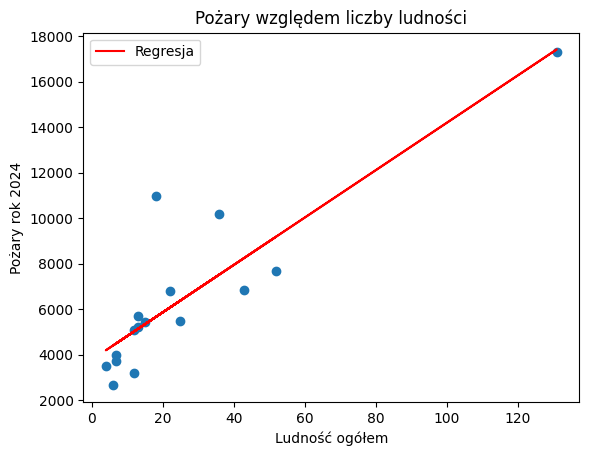

In [68]:
pl.plot_regr_poz_lud(df_lud_zez_poz.liczba_zezwolen, df_lud_zez_poz['Pożary rok 2024'])
#df_lud_zez_poz.head()

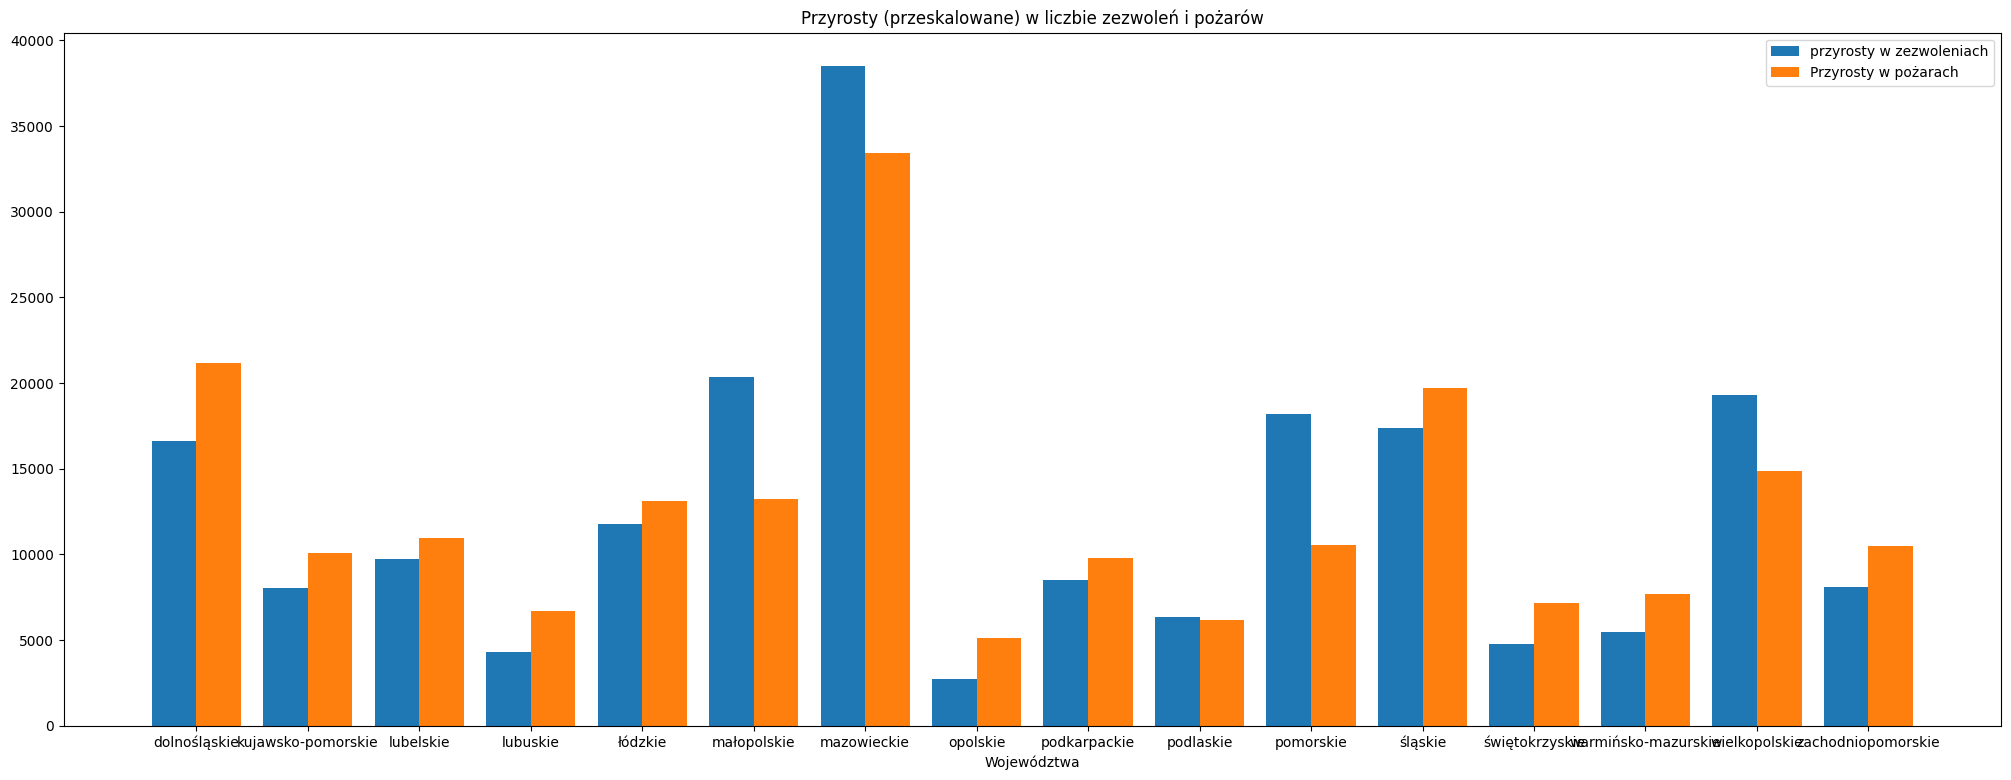

In [51]:
miesz_pozar = pd.merge(mieszk, pozary_grup_woj, on = "Województwo")
pl.barplot_dwa(miesz_pozar.nowe_mieszkania_2024, miesz_pozar["Pożary rok 2024"], miesz_pozar.Województwo, os ="Województwa", 
            tytul = "Zależność między liczbą nowych mieszkań, a liczbą pożarów", legenda = ["nowe mieszkania", "liczba pożarów"])

In [61]:
print(miesz_pozar[['nowe_mieszkania_2024', "Pożary rok 2024"]].corr())

                      nowe_mieszkania_2024  Pożary rok 2024
nowe_mieszkania_2024               1.00000          0.91525
Pożary rok 2024                    0.91525          1.00000
